min_df = 2
dimension reduction method: LSI
The accuracy is:
0.8428571428571429
The precision is:
0.9024943310657596
The recall is:
0.7653846153846153
The confusion matrix is:
[[1461  129]
 [ 366 1194]]


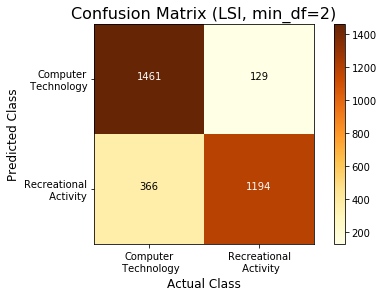

The range of threshold is:
2.0
6.813582646526084e-19
min_df = 5
dimension reduction method: LSI
The accuracy is:
0.8447619047619047
The precision is:
0.8987341772151899
The recall is:
0.7737179487179487
The confusion matrix is:
[[1454  136]
 [ 353 1207]]


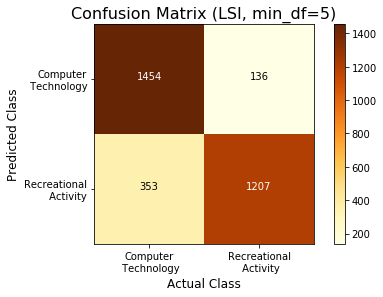

The range of threshold is:
2.0
1.2180487253095772e-16
min_df = 2
dimension reduction method: NMF
The accuracy is:
0.9130158730158731
The precision is:
0.9652677279305355
The recall is:
0.8551282051282051
The confusion matrix is:
[[1542   48]
 [ 226 1334]]


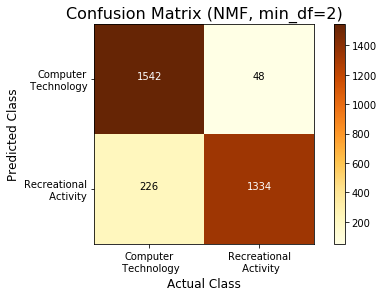

The range of threshold is:
2.0
0.0


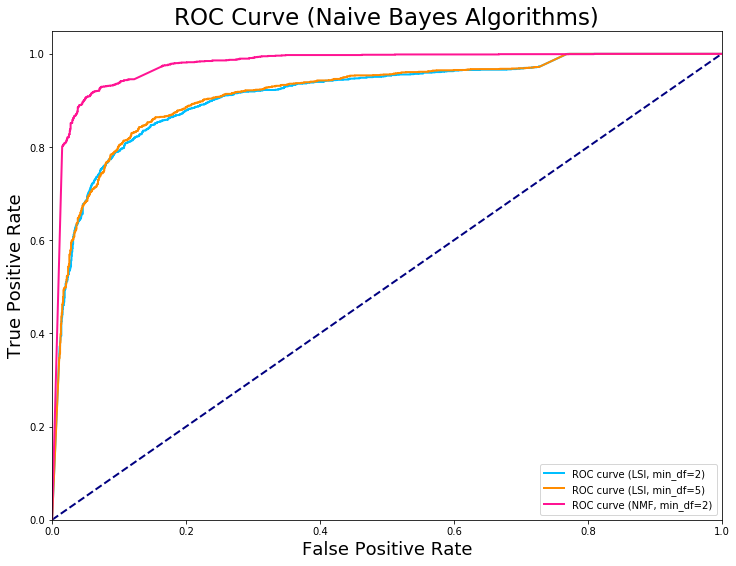

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import re
from sklearn.metrics import confusion_matrix
import itertools


# fetch original data
computer_technology_subclasses = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
recreational_activity_subclasses = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
comp_tech_train = fetch_20newsgroups(subset='train', categories=computer_technology_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
rec_act_train = fetch_20newsgroups(subset='train', categories=recreational_activity_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
comp_tech_test = fetch_20newsgroups(subset='test', categories=computer_technology_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
rec_act_test = fetch_20newsgroups(subset='test', categories=recreational_activity_subclasses, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
all_data = comp_tech_train.data+comp_tech_test.data+rec_act_train.data+rec_act_test.data


# map comp_tech class to True and rec_act class to False
classification_train = [True] * len(comp_tech_train.data) + [False] * len(rec_act_train.data)
classification_test = [True] * len(comp_tech_test.data) + [False] * len(rec_act_test.data)


# trim data
stemmer = SnowballStemmer("english")
def trim_and_stem(data_list):
    for i in range(len(data_list)):
        temp = re.findall('[a-zA-Z]+', data_list[i])
        ans = []
        for j in range(len(temp)):
            if not temp[j].isdigit():
                ans.append(stemmer.stem(temp[j])) # stem() turned words into lowercase            
        data_list[i] = " ".join(ans)
trim_and_stem(all_data)


# generate count matrices with min_df = 2 & 5
X_counts = []
for i in [2, 5]:
    count_vect = CountVectorizer(min_df=i, stop_words ='english')
    X_counts.append(count_vect.fit_transform(all_data))


# generate tfidf matrices 
tfidf_transformer = TfidfTransformer()
X_tfidf = []
for i in [0, 1]:
    X_tfidf.append(tfidf_transformer.fit_transform(X_counts[i]))


# extract feature using LSI & NMF
lsi_res = []
svd = TruncatedSVD(n_components = 50, n_iter = 10,random_state = 42)
for i in [0, 1]:
    lsi_res.append(svd.fit_transform(X_tfidf[i]))
nmf = NMF(n_components=50, init='random', random_state=0)
nmf_res = nmf.fit_transform(X_tfidf[0])


# split train and test dataset
split_point_1 = len(comp_tech_train.data)
split_point_2 = split_point_1 + len(comp_tech_test.data)
split_point_3 = split_point_2 + len(rec_act_train.data)
lsi_test = []
lsi_train = []
for i in [0, 1]:
    lsi_test.append(np.concatenate((lsi_res[i][split_point_1 : split_point_2], lsi_res[i][split_point_3:])))
    lsi_train.append(np.concatenate((lsi_res[i][0:split_point_1], lsi_res[i][split_point_2:split_point_3])))
nmf_test = np.concatenate((nmf_res[split_point_1 : split_point_2], nmf_res[split_point_3:]))
nmf_train = np.concatenate((nmf_res[0:split_point_1], nmf_res[split_point_2:split_point_3]))
lsi_test += [nmf_test]
lsi_train += [nmf_train]
test = lsi_test
train = lsi_train

method = ['LSI', 'LSI', 'NMF']
min_df = [2, 5, 2]
fprs = []
tprs = []

# plot confusion matrix
class_names = ['Computer\n Technology', 'Recreational\n Activity']
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.YlOrBr):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted Class', fontsize=12)
    plt.xlabel('Actual Class', fontsize=12)


# predict data
for i in range(3):
    #Use Gaussian Naive Bayes method
    classifier = GaussianNB()
    #Fit the model
    classifier.fit(train[i], classification_train)
    #Calculate the result & accuracy
    result=classifier.predict(test[i])
    accuracy = classifier.score(test[i], classification_test)
    #Calculate the probability estimates of the positive class
    prob_data = classifier.predict_proba(test[i])
    prob_data = prob_data[:,1]
    #Calculate fpr & ftr 
    fpr,tpr,thresholds=metrics.roc_curve(classification_test, prob_data)
    fprs.append(fpr)
    tprs.append(tpr)
    #Calculate confusion matrix, precision & recall
    conf_mat = metrics.confusion_matrix(classification_test, result)
    precision = metrics.precision_score(classification_test, result)
    recall = metrics.recall_score(classification_test, result)
    roc_auc=metrics.auc(fpr,tpr)

    print 'min_df = ' + str(min_df[i])
    print 'dimension reduction method: ' + str(method[i])
    print 'The accuracy is:'
    print accuracy
    print 'The precision is:'
    print precision
    print 'The recall is:'
    print recall
    print 'The confusion matrix is:'
    print conf_mat
    # Plot non-normalized confusion matrix
    plt.figure()
    title = 'Confusion Matrix ('+method[i]+', min_df='+str(min_df[i])+')'
    plot_confusion_matrix(conf_mat, classes=class_names, title=title)
    plt.show()
    print 'The range of threshold is:'
    print thresholds[0]
    print thresholds[len(thresholds)-1]
    

# plot ROC curve
plt.figure(figsize=(12,9))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve (Naive Bayes Algorithms)', fontsize=23)
color = ['deepskyblue', 'darkorange', 'deeppink']
for i in range(3):
    plt.plot(fprs[i], tprs[i], color=color[i], lw=2, label='ROC curve ('+method[i]+', min_df='+str(min_df[i])+')')
plt.legend(loc="lower right")
plt.show()
